# Collaboration and Competition Project 3

---

Third hands-on project of the Deep Reinforcement Learning Nanodegree.

Note: as mentioned as a tip by the course leader the code is oriented by the solutions teached during the drl - nanodegree.

### 1. Start the Environment
Importing some necessary packages.

In [1]:
import sys
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Define Agent and Traning

#### Model and Agent
For this project, agents architecture of [Project 2](https://github.com/Leschek-Kop/DDPG-Continuous-Control-Reacher) is used and modified (code in `ddpg_agent.py`). In `maddpg_agents.py` a wrapper as a multi agent handler is defined to solve the multi agent reinforcement learning task (MARL).

The main model behind the ddpg is an actor - critic architecture. You can define the agents NN by setting the input_size, hidden_layers and output_size. The definition for hidden_layers, e.g. `hidden_layers=[10, 12]`, will be interpreted as two (2) hidden layers with 10 respectively 12 neurons (a default `hidden_layers=[256, 128]` is set if given hidden_layers=None).

A fully connected forward network with a relu activation function between the layers for Actor and Critic is used.

The Actor - Network has a tanh activation function for the output layer. This correlates with the requirements of the environment for the action vector (must be a number between `-1` and `1`).

The DDPG - Agents are defined with target networks and soft-update for actor and critic networks. The `**kwargs` are used to overwrite agents defaults for:
 + BATCH_SIZE = 128
 + BUFFER_SIZE = int(1e5)
 + GAMMA = 0.99
 + LR_ACTOR = 1e-3
 + LR_CRITIC = 1e-3
 + TAU = 1e-3
 + SIGMA = 0.2

If cuda is available, the agent will try to prefer cuda over cpu for training. Parameter for soft update is given by the hyperparameter `TAU`. The Exploration-Exploitation problem is addressed by the Ornstein-Uhlenbeck process (for additional action noise). Parameter `SIGMA` is used to weight the additional noise.

As optimizer the SGD - Adam optimizer (with momentum) is used for better performance.
The learning algorithm to train the MADDPG Agents is realized with an Ornstein-Uhlenbeck process to define the exploration-exploitation during training. 

As an option a shared replay buffer can be set with an additional key-word-argument `MEMORY`.

In [2]:
from maddpg_agents import MultiAgents
from ddpg_agent import Agent as DDPGAgent

#### Training and Results
A function to plot the scores (in blue) and optional average scores (in red) over episodes with (inline) matplotlib is provided.

The multi agent ddpg-training function (multi_ddpg) is set with parameters to define the training and the monitoring.

In [4]:
def plot_scores(scores, scores_avg=None):
    """Plot scores ans average (option).

    Params
    ======
        scores (array): List of Rewards per Episode
        scores_all_avg (array): List of moving average of reward per Episode
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    if not scores_avg == None:
        plt.plot(np.arange(len(scores)), scores, label='Scores', color='blue')
        plt.plot(np.arange(len(scores_avg)), scores_avg, label='Average', color='red')
        # show a legend on the plot
        plt.legend()
    else:
        plt.plot(np.arange(len(scores)), scores)
    plt.show()

def multi_ddpg(env, brain_name, maddpg, num_agents, n_episodes=10000, queue=100,
               print_every=100, stop_solved=0.5, chkpoint_name='checkpoint'):
    """Train DDPG Agent.

        Params
        ======
            env (object): Reacher Environment
            brain_name (object): Env brain name
            maddpg (object): MADDPG Object, wrapper to handle multiple agents
            num_agents (int): Number of agent in environment
            n_episodes (int): Number of episodes
            queue (int): window for monitoring purposes. Defines the rewards average
            print_every (int): parameter for fixed print information in terminal
            stop_solved (float): mean reward over specific windows size to achieve, defined by parameter queue
            chkpoint_name (string): suffix for checkpoint names for critic_* and actor_* checkpoint

        Return
        ======
            scores_all (array): List of Rewards per Episode
            scores_all_avg (array): List of moving average of reward per Episode over window size defined by parameter "queue"
        """
    scores_window = deque(maxlen=queue)
    scores_all = []
    scores_all_avg = []
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        maddpg.reset()  # reset agents exploration weights
        states = env_info.vector_observations  # get the current state
        scores = np.zeros(num_agents)  # initialize the score (for each agent)
        while True:
            actions = maddpg.act(states, add_noise=True)  # select an action for each agent, clipped between -1 and 1
            env_info = env.step(actions)[brain_name]  # send all actions to the environment
            next_states = env_info.vector_observations  # get env next states
            rewards = env_info.rewards  # get reward for each agent
            dones = env_info.local_done  # see if episode finished for any agent
            maddpg.step(states, actions, rewards, next_states, dones)  # Save and learn
            scores += rewards  # update the score for each agent
            states = next_states  # roll over states to next time step
            if np.any(dones):  # exit loop if episode finished for any agent
                break
        scores_window.append(np.amax(scores))
        scores_all.append(np.amax(scores))
        scores_all_avg.append(np.mean(scores_window))

        """Print progress"""
        print('\rEpisode {}\tReward: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, np.amax(scores),
                                                                           np.mean(scores_window)), end="")
        if i_episode % print_every == 0:
            """Print progress and keep it in console log"""
            print('\rEpisode {}\tReward: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, np.amax(scores),
                                                                               np.mean(scores_window)))
        if np.mean(scores_window) >= stop_solved:
            """Goal reached, save weights and quit."""
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            maddpg.save_chkpoints(chkpoint_name)
            break

    return scores_all, scores_all_avg

### 3. Train Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

After the environment is loaded environments **Brain** has to be defined. Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
env = UnityEnvironment(file_name="Tennis.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


###  Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of `+0.1`. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of `-0.01`. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of `8` variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

In the last code cell some additional information about the environment are printed.

###### Start Training:

The next code cell will define an  MADDPG-Agent and the training environment. Two agents are defined with:

 + hidden_layers_actor = [512, 256, 64]      # 3 Hidden layers with 512, 256 and 64 neurons.
 + hidden_layers_critic = [512, 256, 64]     # 3 Hidden layers with 512, 256 and 64 neurons.
 + GAMMA = 0.99
 + LR_ACTOR = 1e-4
 + LR_CRITIC = 1e-4
 + TAU = 1e-3
 + SIGMA = 0.1

For the MADDPG a `MEMORY_MODE = 2` is set for a shered repley buffer. Parameter for the buffer are:

 + BATCH_SIZE = 256
 + BUFFER_SIZE = int(1e6)

The training is set to max. 10000 episodes (eps) and will stop if the average reward will hit `>= 0.5` (stop_solved).
The task is episodic, and in order to solve the environment, the agent must get an average score of `0.5` over `100` consecutive episodes.

The task is a collaboration and competition one. Both agents trying to max. their own reward by keeping the ball as long as possible in the game.

Results for the defined agent are plotted below the code cell as well as the number of episodes needed to solve the environment.


#### Start training with '2' agents ####
Episode 100	Reward: -0.00	Average Score: 0.00
Episode 200	Reward: -0.00	Average Score: 0.01
Episode 300	Reward: -0.00	Average Score: 0.00
Episode 400	Reward: -0.00	Average Score: 0.00
Episode 500	Reward: -0.00	Average Score: 0.00
Episode 600	Reward: -0.00	Average Score: 0.00
Episode 700	Reward: -0.00	Average Score: 0.00
Episode 800	Reward: -0.00	Average Score: 0.00
Episode 900	Reward: -0.00	Average Score: 0.01
Episode 1000	Reward: -0.00	Average Score: 0.01
Episode 1100	Reward: -0.00	Average Score: 0.00
Episode 1200	Reward: -0.00	Average Score: 0.01
Episode 1300	Reward: -0.00	Average Score: 0.02
Episode 1400	Reward: -0.00	Average Score: 0.00
Episode 1500	Reward: -0.00	Average Score: 0.00
Episode 1600	Reward: -0.00	Average Score: 0.00
Episode 1700	Reward: -0.00	Average Score: 0.00
Episode 1800	Reward: -0.00	Average Score: 0.02
Episode 1900	Reward: 0.05	Average Score: 0.022
Episode 2000	Reward: 0.05	Average Score: 0.044
Episode 2100	Reward: 0.05	A

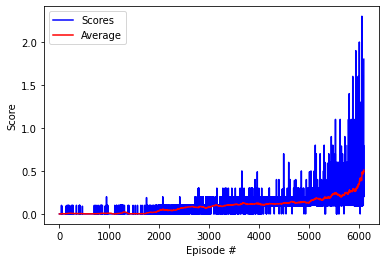

In [6]:
seed_ = 0
env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
states = env_info.vector_observations  # test set of environments states
num_agents = len(env_info.agents)
state_size = states.shape[1]  # num states
action_size = brain.vector_action_space_size  # num actions
state_size = state_size * num_agents
hidden_layers_actor = [256, 128, 64]
hidden_layers_critic = [256, 128, 64]
eps = 10000
date = 20210704
suffix = 'SOLVED'
print("\n#### Start training with '{}' agents ####".format(num_agents), end="\n")
sys.stdout.flush()

# Define Agents
ddpg_config_list = [
    {"state_size": state_size, "action_size": action_size, "seed": seed_, "hidden_layers_actor": hidden_layers_actor,
     "hidden_layers_critic": hidden_layers_critic, "kwargs": {"BATCH_SIZE": 256, "BUFFER_SIZE": int(1e6), "GAMMA": 0.99,
                                                              "LR_ACTOR": 1e-3, "LR_CRITIC": 1e-3, "TAU": 1e-3, 
                                                              "SIGMA": 0.1}
    },
    {"state_size": state_size, "action_size": action_size, "seed": seed_, "hidden_layers_actor": hidden_layers_actor,
     "hidden_layers_critic": hidden_layers_critic, "kwargs": {"BATCH_SIZE": 256, "BUFFER_SIZE": int(1e6), "GAMMA": 0.99,
                                                              "LR_ACTOR": 1e-3, "LR_CRITIC": 1e-3, "TAU": 1e-3, 
                                                              "SIGMA": 0.1}
    }
]
# Define MARL settings
maddpg_config = {
    "STATE_SIZE": state_size,
    "ACTION_SIZE": action_size,
    "NUM_AGENTS": num_agents,
    "MEMORY": [{
        "action_size": action_size,
        "buffer_size": int(1e6),
        "batch_size": 256,
        "seed": seed_
    }],
    "MEMORY_MODE": 2  # 2: Shared relay buffer
}
multiagents = MultiAgents(ddpg_config_list, maddpg_config)

# Start training
scores, scores_avg = multi_ddpg(env, brain_name, multiagents, num_agents=num_agents,
                                         n_episodes=eps, queue=100, print_every=100, stop_solved=0.5,
                                         chkpoint_name="checkpoint_{}_{}_{}_{}".format(num_agents, eps, date, suffix))
# plot the scores
plot_scores(scores, scores_avg)

### 4. Watch your trained Agent
Use the trained weights and watch the agent acting in the environment.

In [7]:
for i in range(1, 5):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = multiagents.act(states, add_noise=True)  # select an action for each agent, clipped between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.4000000059604645
Score (max over agents) from episode 2: 0.20000000298023224
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.10000000149011612


### 5. Finish
When finished, you can close the environment by running the following command.

In [8]:
env.close()

### Ideas for Future Work

There are a lot of improvements to make. Some of them are:
 + Add parameter noise for exploration
 + Add batch normalization to improve learn performance
 + prioritized experience replay
 + Test an marl achitecture with shared critic
 + Run a empirical case study for hyperparameter alpha (LR - learning Rate) for actor and critic and tau ( for softupdate ) to improve performance.